<a href="https://colab.research.google.com/github/DeveshVishal/Skin_Disease-Cancer-/blob/main/SkinDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import keras
from keras import backend as K
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import glob
import zipfile
import random
import cv2
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)
class_names = ["benign", "malignant"]

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [ ]:
train_url = "drive/My Drive/Skin_Disease/train"
valid_url = "drive/My Drive/Skin_Disease/valid"
test_url = "drive/My Drive/Skin_Disease/test"

In [ ]:
def generate_csv(folder, labels):
    folder_name = os.path.basename(folder)
    label2int = {}
    if labels:
        labels = labels.split(",")
        for label in labels:
            string_label, integer_label = label.split("=")
            label2int[string_label] = integer_label

    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)


generate_csv(train_url, "nevus=0,seborrheic_keratosis=0,melanoma=1")
generate_csv(valid_url, "nevus=0,seborrheic_keratosis=0,melanoma=1")
generate_csv(test_url, "nevus=0,seborrheic_keratosis=0,melanoma=1")

Reading drive/My Drive/Skin_Disease/train/nevus/*
Reading drive/My Drive/Skin_Disease/train/seborrheic_keratosis/*
Reading drive/My Drive/Skin_Disease/train/melanoma/*
Saving train.csv
Reading drive/My Drive/Skin_Disease/valid/nevus/*
Reading drive/My Drive/Skin_Disease/valid/seborrheic_keratosis/*
Reading drive/My Drive/Skin_Disease/valid/melanoma/*
Saving valid.csv
Reading drive/My Drive/Skin_Disease/test/nevus/*
Reading drive/My Drive/Skin_Disease/test/seborrheic_keratosis/*
Reading drive/My Drive/Skin_Disease/test/melanoma/*
Saving test.csv


In [ ]:
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples: 2000
Number of validation samples: 150


In [ ]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label


valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (299, 299, 3)
Label: 0


In [ ]:
batch_size = 64
optimizer = "rmsprop"

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.repeat()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

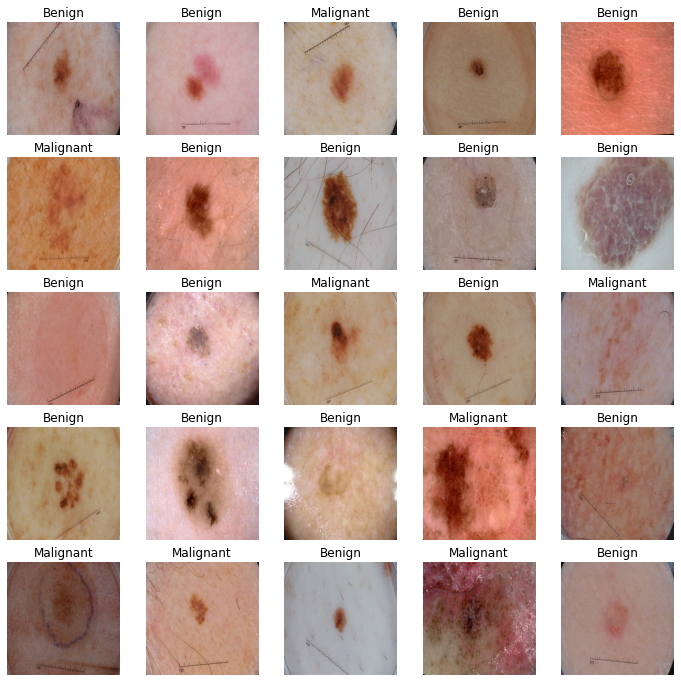

In [ ]:
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')
        
show_batch(batch)

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, 299, 299, 3])
m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
# saves model checkpoint whenever we reach better weights
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds, validation_data=valid_ds, 
                steps_per_epoch=n_training_samples // batch_size, 
                validation_steps=n_validation_samples // batch_size, verbose=1, epochs=100,
                callbacks=[tensorboard, modelcheckpoint])

Epoch 1/100
Epoch 1/100
 1/31 [..............................] - ETA: 0s - loss: 0.9319 - accuracy: 0.1719WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


31/31 [==============================] - ETA: 0s - loss: 0.4575 - accuracy: 0.7772 
Epoch 00001: val_loss improved from inf to 0.56766, saving model to benign-vs-malignant_64_rmsprop_0.568.h5

Epoch 00001: val_loss improved from inf to 0.56766, saving model to benign-vs-malignant_64_rmsprop_0.568.h5
31/31 [==============================] - 1021s 33s/step - loss: 0.4575 - accuracy: 0.7772 - val_loss: 0.5677 - val_accuracy: 0.7891
Epoch 2/100
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8034 
Epoch 00002: val_loss improved from 0.56766 to 0.49351, saving model to benign-vs-malignant_64_rmsprop_0.494.h5

Epoch 00002: val_loss improved from 0.56766 to 0.49351, saving model to benign-vs-malignant_64_rmsprop_0.494.h5
31/31 [==============================] - 411s 13s/step - loss: 0.4065 - accuracy: 0.8034 - val_loss: 0.4935 - val_accuracy: 0.8047
Epoch 3/100
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.3828 - accuracy: 0.8

In [ ]:
# import torch
# from torchvision import datasets, models, transforms

In [ ]:
# model = models.resnet152(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
# model_save_name = 'classifier.pt'
# path = F"/content/drive/My Drive/Skin_Disease/{model_save_name}" 
# torch.save(model.state_dict(), path)

In [ ]:
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  return ds

test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")


Number of testing samples: 600


In [ ]:
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [20]:
m.load_weights("/content/drive/My Drive/Skin_Disease/model/benign-vs-malignant_64_rmsprop_0.386.h5")

In [21]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  Accuracy:", accuracy)

Evaluating the model...
Loss: 0.45641952753067017   Accuracy: 0.7983333468437195


In [22]:
def get_predictions(threshold=None):
  y_pred = m.predict(X_test)
  if not threshold:
    threshold = 0.5
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    if y_pred[i][0] >= threshold:
      result[i] = 1
  return result

threshold = 0.23
y_pred = get_predictions(threshold)

[[0.58385093 0.41614907]
 [0.29059829 0.70940171]]


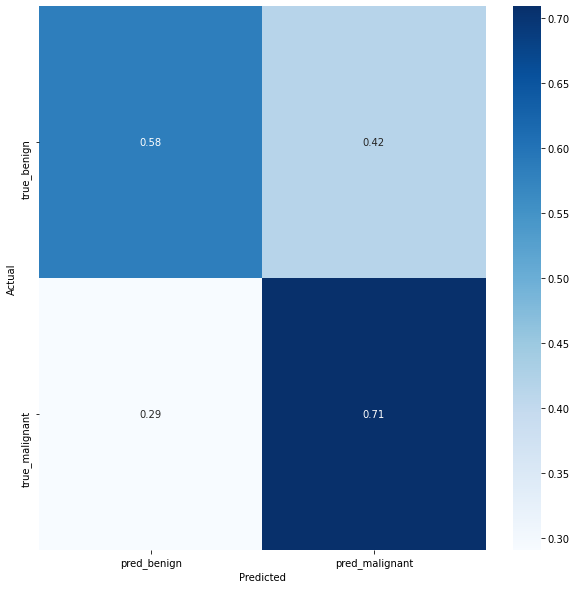

In [23]:
# def plot_confusion_matrix(y_test, y_pred):
#   cmn = confusion_matrix(y_test, y_pred)
#   cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
#   print(cmn)
#   fig, ax = plt.subplots(figsize=(10,10))
#   sns.heatmap(cmn, annot=True, fmt='.2f', 
#               xticklabels=[f"pred_{c}" for c in class_names], 
#               yticklabels=[f"true_{c}" for c in class_names],
#               cmap="Blues"
#               )
#   plt.ylabel('Actual')
#   plt.xlabel('Predicted')
#   plt.show()

# plot_confusion_matrix(y_test, y_pred)

In [24]:
sensitivity = sensitivity_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print("Melanoma Sensitivity:", sensitivity)
print("Melanoma Specificity:", specificity)

Melanoma Sensitivity: 0.7094017094017094
Melanoma Specificity: 0.5838509316770186


ROC AUC: 0.647


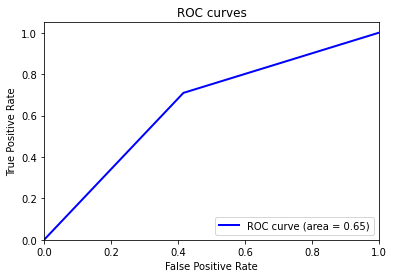

In [25]:
# def plot_roc_auc(y_true, y_pred):
#     plt.figure()
#     fpr, tpr, _ = roc_curve(y_true, y_pred)
#     roc_auc = auc(fpr, tpr)
#     print(f"ROC AUC: {roc_auc:.3f}")
#     plt.plot(fpr, tpr, color="blue", lw=2,
#                 label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC curves')
#     plt.legend(loc="lower right")
#     plt.show()

# plot_roc_auc(y_test, y_pred)

In [26]:
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, 299, 299, 3])
# m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [44]:
img = cv2.imread("/content/drive/My Drive/Skin_Disease/test/melanoma/ISIC_0012425.jpg")

In [45]:
img = cv2.resize(img,(299,299))

In [46]:
img = np.expand_dims(img,axis=0)

In [47]:
img.shape

(1, 299, 299, 3)

In [48]:
y_pred = m.predict(img)

In [35]:
image = cv2.imread("/content/drive/My Drive/Skin_Disease/test/melanoma/ISIC_0012425.jpg")

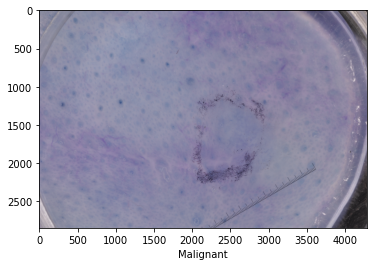

In [51]:
if y_pred < 0.5 :
  plt.xlabel("Malignant")
else :
  plt.xlabel("Bening")
plt.imshow(image)